# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
1420  HAM_0004884            ISIC_0032128.jpg    bkl      histo  75.0    male  \
5149  HAM_0002129  aug_98T5wOISIC_0025903.jpg     df  consensus  60.0    male   
4996  HAM_0004090  aug_3vhmj3ISIC_0031271.jpg     df  consensus  45.0  female   
18    HAM_0007244            ISIC_0030669.jpg     nv  follow_up  40.0    male   
3168  HAM_0003216            ISIC_0034223.jpg    bcc      histo  85.0  female   
4649  HAM_0005330  aug_BSctsOISIC_0024553.jpg     df  consensus  50.0  female   
1136  HAM_0003715            ISIC_0026941.jpg    bkl  consensus  70.0  female   
2330  HAM_0006423            ISIC_0028685.jpg    mel      histo  55.0    male   
314   HAM_0003924            ISIC_0030569.jpg     nv  follow_up  80.0    male   
2594  HAM_0000321            ISIC_0033183.jpg    mel      histo  70.0    male   
5234  HAM_0007051  aug_GPoTVRISIC_0031002.jpg     df      histo  65.0    male   
2542  HAM_0000799            ISIC_0033586.jpg    mel      histo  65.0    male   
3810  HAM_0006203            ISIC_0026456.jpg   vasc      histo  60.0    male   
301   HAM_0005786            ISIC_0026491.jpg     nv      histo  50.0  female   
1676  HAM_0004363            ISIC_0031609.jpg  akiec      histo  55.0    male   

         localization        dataset        dx_binary     dx_tertiary   
1420  upper extremity   vidir_modern  not_skin_cancer  non-neoplastic  \
5149          abdomen  vidir_molemax  not_skin_cancer  non-neoplastic   
4996  lower extremity  vidir_molemax  not_skin_cancer  non-neoplastic   
18            abdomen  vidir_molemax  not_skin_cancer          benign   
3168             face   vidir_modern      skin_cancer       malignant   
4649  upper extremity  vidir_molemax  not_skin_cancer  non-neoplastic   
1136            trunk  vidir_molemax  not_skin_cancer  non-neoplastic   
2330             back      rosendahl      skin_cancer       malignant   
314             trunk  vidir_molemax  not_skin_cancer          benign   
2594             back   vidir_modern      skin_cancer       malignant   
5234  upper extremity   vidir_modern  not_skin_cancer  non-neoplastic   
2542  upper extremity   vidir_modern      skin_cancer       malignant   
3810  upper extremity   vidir_modern  not_skin_cancer  non-neoplastic   
301   upper extremity      rosendahl  not_skin_cancer          benign   
1676             face      rosendahl      skin_cancer       malignant   

                                     image_path  
1420            ./../data/jpgs/ISIC_0032128.jpg  
5149  ./../data/jpgs/aug_98T5wOISIC_0025903.jpg  
4996  ./../data/jpgs/aug_3vhmj3ISIC_0031271.jpg  
18              ./../data/jpgs/ISIC_0030669.jpg  
3168            ./../data/jpgs/ISIC_0034223.jpg  
4649  ./../data/jpgs/aug_BSctsOISIC_0024553.jpg  
1136            ./../data/jpgs/ISIC_0026941.jpg  
2330            ./../data/jpgs/ISIC_0028685.jpg  
314             ./../data/jpgs/ISIC_0030569.jpg  
2594            ./../data/jpgs/ISIC_0033183.jpg  
5234  ./../data/jpgs/aug_GPoTVRISIC_0031002.jpg  
2542            ./../data/jpgs/ISIC_0033586.jpg  
3810            ./../data/jpgs/ISIC_0026456.jpg  
301             ./../data/jpgs/ISIC_0026491.jpg  
1676            ./../data/jpgs/ISIC_0031609.jpg

## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [3]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

In [4]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


### Control: Show some images from the train data set after preprocessing

In [5]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [6]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


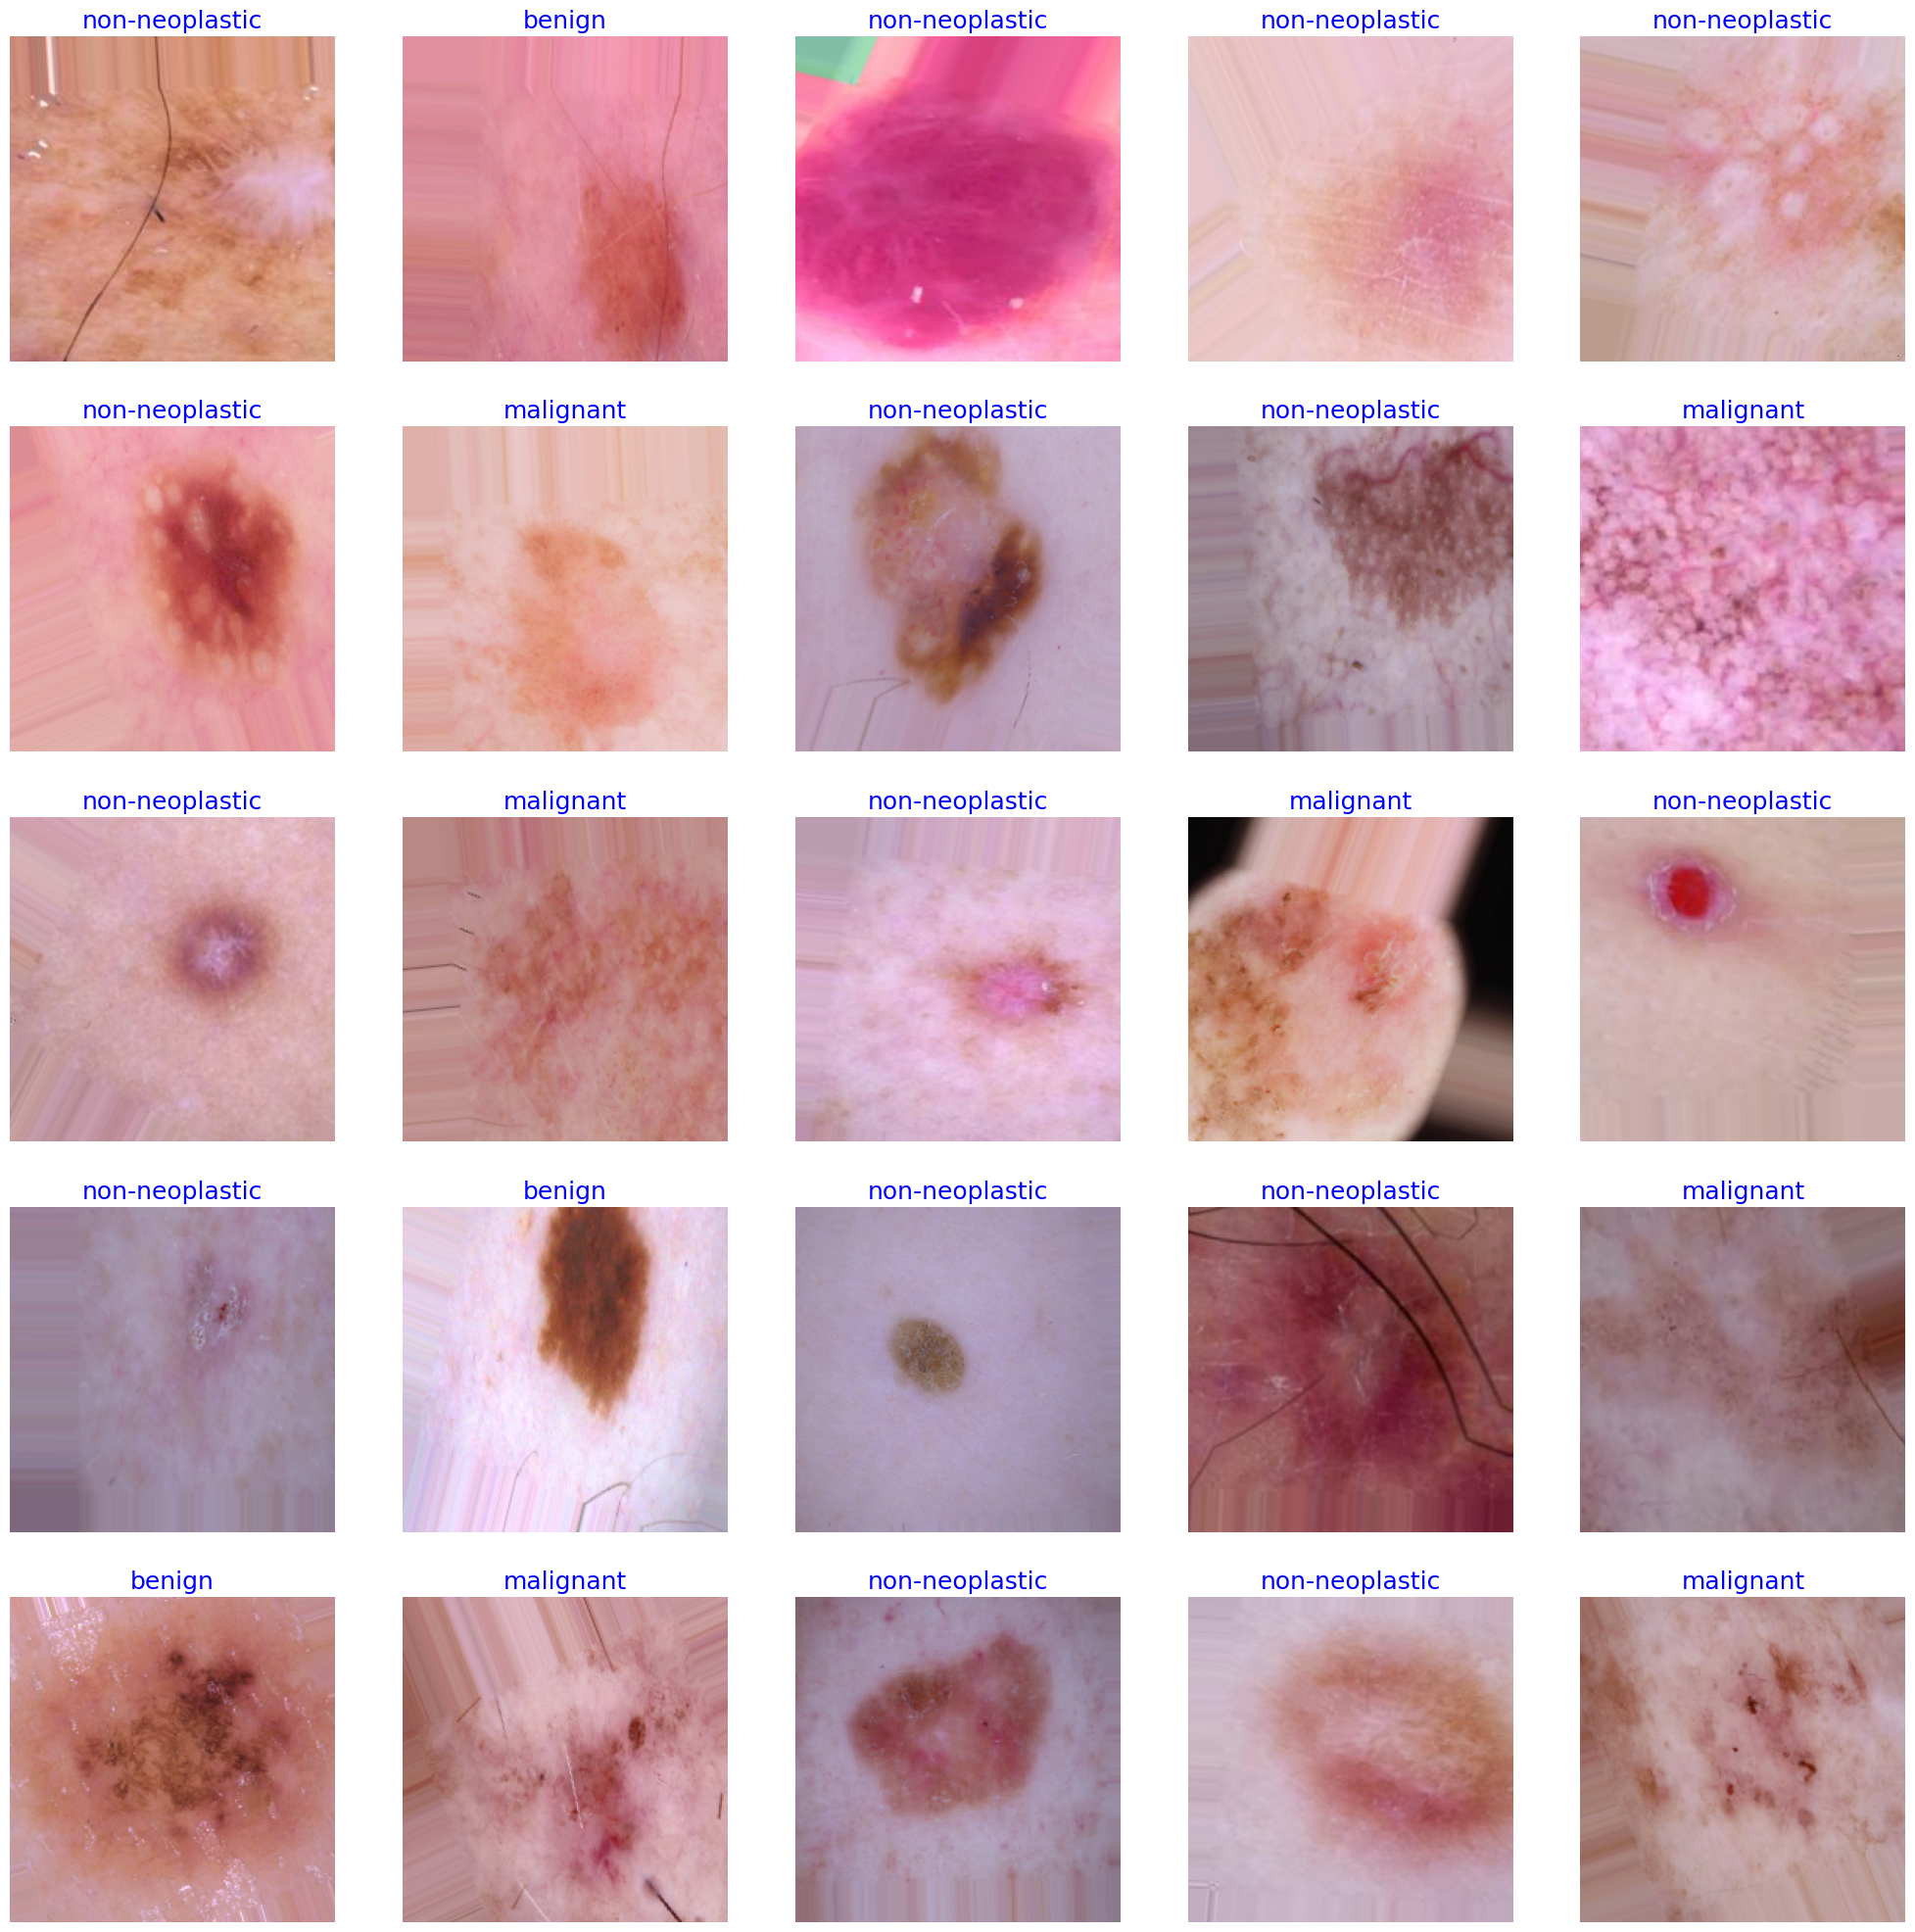

In [7]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [8]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [9]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

#### Model architecture

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.5))(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
x= Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.5))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name='Resnet50_tertiary_baseline_l2_regularization_01')

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_score])

# Print model summary
model.summary()

Model: "Resnet50_tertiary_baseline_l2_regularization_01"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                

### Callback functions

#### Learning rate scheduler for model compilation

In [11]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Class weights 

In [12]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

#### Early stopping

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=10,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

## Model Training

In [14]:
# Train the model
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=NUM_EPOCHS,  # Number of training epochs
    verbose=1,  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,  # Batch size for training
    callbacks=[lr_scheduler, early_stopping],  # List of callbacks to apply during training
    validation_split=0.0,  # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,  # Shuffle the training data before each epoch
    sample_weight=None,  # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,  # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,  # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,  # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,  # Frequency to validate the model on the validation set
    max_queue_size=10,  # Maximum size of the generator queue
    workers=-1,  # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False  # Use multiprocessing for data generation (True or False)
)

Epoch 1/20
165/165 [==============================] - 993s 6s/step - loss: 27.9917 - accuracy: 0.7077 - f1_score: 0.6862 - val_loss: 8.3380 - val_accuracy: 0.6693 - val_f1_score: 0.6668 - lr: 1.0000e-04
Epoch 2/20
165/165 [==============================] - 1270s 8s/step - loss: 4.4394 - accuracy: 0.7887 - f1_score: 0.7790 - val_loss: 3.5523 - val_accuracy: 0.6673 - val_f1_score: 0.5430 - lr: 1.0000e-04
Epoch 3/20
165/165 [==============================] - 1744s 11s/step - loss: 2.5362 - accuracy: 0.8095 - f1_score: 0.8055 - val_loss: 3.1279 - val_accuracy: 0.3986 - val_f1_score: 0.3445 - lr: 1.0000e-04
Epoch 4/20
165/165 [==============================] - 1462s 9s/step - loss: 2.1088 - accuracy: 0.8291 - f1_score: 0.8227 - val_loss: 2.8810 - val_accuracy: 0.5425 - val_f1_score: 0.5305 - lr: 1.0000e-04
Epoch 5/20
165/165 [==============================] - 1339s 8s/step - loss: 1.8312 - accuracy: 0.8612 - f1_score: 0.8552 - val_loss: 2.6783 - val_accuracy: 0.5994 - val_f1_score: 0.5965 -

## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

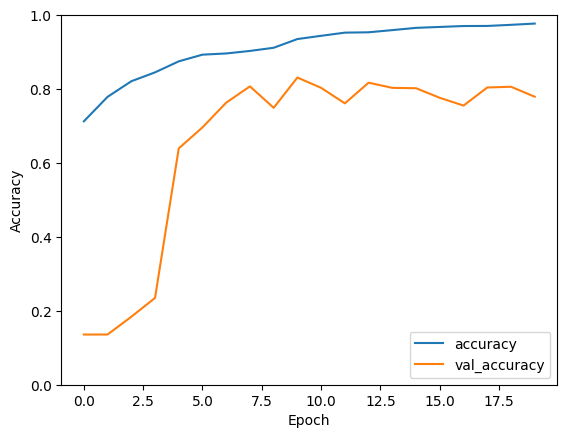

In [ ]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

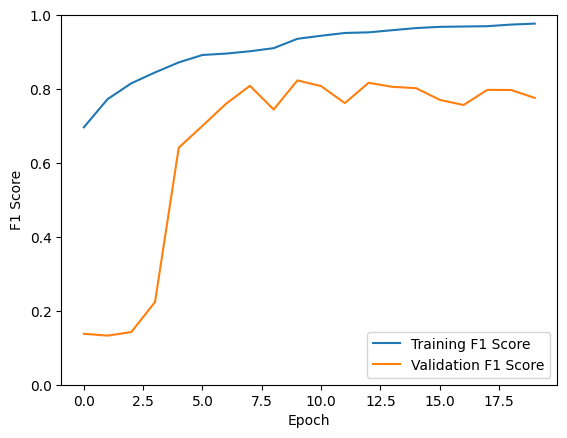

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

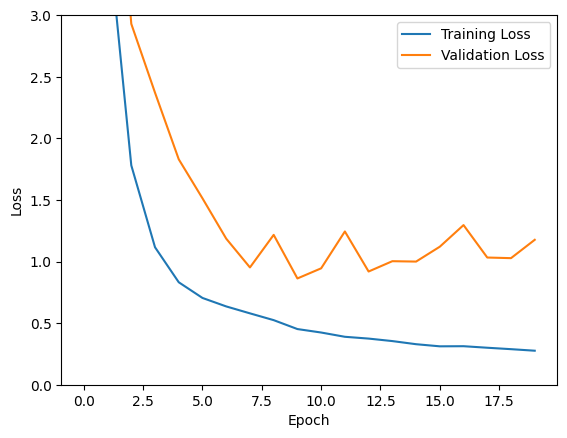

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_baseline_l2_regularization_01:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 40s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.9388583143171069
 > Micro AUC: 0.9568965860693783


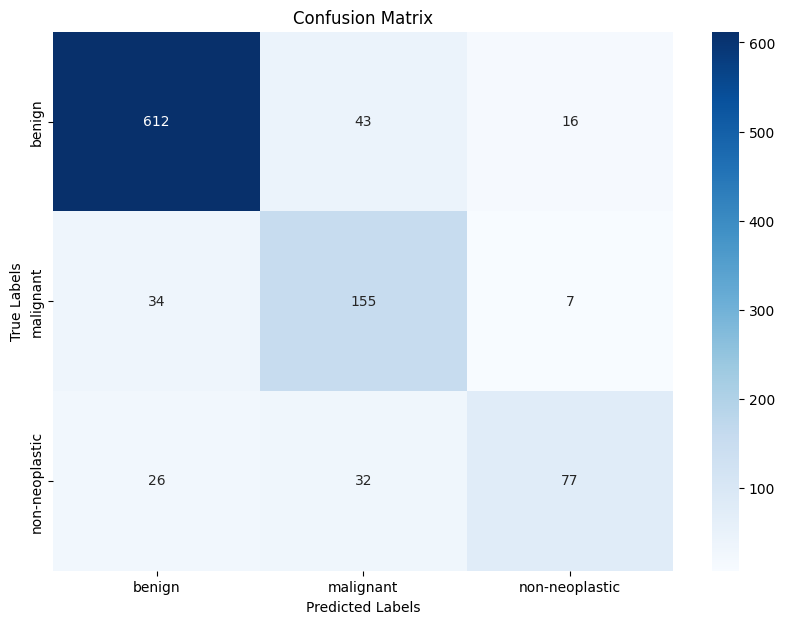



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       671
           1       0.67      0.79      0.73       196
           2       0.77      0.57      0.66       135

    accuracy                           0.84      1002
   macro avg       0.78      0.76      0.76      1002
weighted avg       0.85      0.84      0.84      1002

 > Evaluating model on test set...
32/32 [==============================] - 41s 1s/step - loss: 0.8867 - accuracy: 0.8423 - f1_score: 0.8329
loss: 0.8866845965385437
accuracy: 0.8423153758049011
f1_score: 0.8329437375068665
 > Done.


([{'loss': 0.8866845965385437},
  {'accuracy': 0.8423153758049011},
  {'f1_score': 0.8329437375068665}],
 array([[612,  43,  16],
        [ 34, 155,   7],
        [ 26,  32,  77]]),
 (0.9568965860693783, 0.9388583143171069))

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Continue Training

In [ ]:
# Continue training for another 10 epochs
additional_epochs = 15
continue_training = False

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)

In [ ]:
# show accuracy plot
if continue_training:
    mh.model_plot_accuracy(history_continued)

In [ ]:
# show evaluation
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

In [ ]:
# save continued model
if continue_training:
    from datetime import datetime
    timestamp = datetime.now()
    model_path = f"../models/model_{timestamp}.h5"
    model.save(model_path)